# Introduction

Animations are a great way to present systems that are behaving dynamically and processing algorithms often results in changes occuring in some part of the system. In this notebook a very simple perceptron algorithm will be animated using Plotly. Initially, the data used will be generated randomly with the labels assigned in such a way as to make the dataset linearly seperable. This will allow the algorithm, a linear classifier, to find a correct solution given enough iterations. Interestingly, Wikipedia states that the perceptron was originally intended to be a machine, and although its first implementation was in the form of software, a perceptron machine was actually built and used for image recognition. Below is an image of the machine, the Mark I Perceptron.

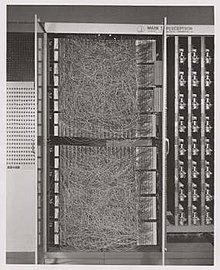

The implementation of the perceptron that will be used here is probably one of the simplest. Initially, two dimensional data will be used and all solutions will be forced through origin. Subsequently an offset will be added and finally, on a real dataset a visualisation of the algorithm working in three dimensions will be presented.

### Import Libraries
Numpy is used to generate the data and pandas to do a little bit of tidying. For the animated graphs plotly's graph objects library is used.

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
np.random.seed(3)

# Data and graph generation - 2D, no offset

Some variables that control the range and amount of data generated are defined. The variable named slope is used to separate the data and label it by generating a line equation and conditionally assigning labels based on the positions of the points relative to this line. This parameter is in itself a valid parameter for a correct decision boundary and this results in the data labels being assigned in a linearly seperable manner. The algorithm will then find this or most probably another solution to the classification problem if enough iterations are available. Since this implementation has no offset, if a [0,0] point is generated then the algorithm cannot find a solution. 

Numpy is used to generate an array with two columns of integers containing the required number of rows. This is converted to a pandas DataFrame. A third column , y, containing the labels is added by using slope to conditionally generate the +1 and -1 labels.
A linspace in the required range is generated, this will be used to draw the boundary line at each iteration in the animation stage. Finally, the weight vector, theta is initialized at [0,0] and a variable T, rapresenting the number of epochs required is declared.

In [ ]:
lower = -10 
upper = 10 
num_points = 30
slope = 0.23 

#data generation
df = pd.DataFrame(np.random.randint(lower, upper + 1, size=(num_points,2)) , columns = ["x1" , "x2"])

#label assignment
df['y'] = np.where(df['x2'] > (slope * df['x1']) , 1 , -1)

#separation into positively labelled and negatively labelled set.
df_pos = df[df['y'] > 0]
df_neg = df[df['y'] < 0]

# linspace, used later in coordinate generation
z = np.linspace(lower, upper, 3)

#theta initialization
theta = [0,0]

#number of epochs
T = 2

df.head()

## Implementing algorithm and visualisation

My approach to using plotly for this animation was quite simple. I searched for some animation examples and studied and hacked the last code example found at https://plotly.com/python/animations/. I will try to relate what I learned from the process below.

In creating an amitated graph, one can think of the process as consisting of two phases - the first stage is where the graph is initialized while in the second stage the frames, containing a snapshot of the data and graph settings for that particular instance, are generated. In this respect, a dictionary is created that will contain the initial data , the layout and the frames of the graph object. These can be filled in any order, but it feels more natural to fill the layout and initial data first. I have to admit, that for a beginner like me, figuring out the layout without the help of the example above would have proved a nightmare. 

As for the data, five traces are used : a trace to plot the vector theta ; a trace to plot the decision boundary ; a trace to plot a marker showing the point which has been processed by the algorithm ; a trace to plot the positively labelled points ; a trace to plot the negatively labelled points.
Note that the first three traces are dynamic in nature while the last two traces are static and thus do not require updating.

Two simple functions are defined to generate the data that will populate the frames:

update_theta determines whether the theta vector is updated by computing the dot product of the point vector theta with the point vector. This results in a scalar with the sign determinig the position of the point with respect to the decision boundary. If this position agrees with the label of the point (resulting in a positive scalar when multiplied with its label) then vector theta is not updated since the classification for that point is correct. Otherwise theta is updated.

coords_lines generates the cordinates of two lines. The decision boundary line is generated by computing the gradient for a line which is orthogonal to the vector theta.  A linear space previously generated by the numpy.linspace function is then multiplied by this gradient to get the coordinates for the second dimension. Fot theta, the coordinates are simply the origin and the vector coordinates themselves. The special case when theta has zero or infinite gradient are defined manually.

The frames are generated iteratively and once the structure is figured out the undertaking is relatively simple. Note that with each iteration only three traces are updated. Order here is important as the updated traces will replace the first three initialized traces. It is therefore important to place static traces at the bottom of the initialization list during the append procedure. An option to update traces by index also exsists but is not used here. The slider steps which are being generated here as well will finally be appended to the layout dictionary.


In [ ]:
# main container
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# initialize layout

fig_dict["layout"]["xaxis"] = {"range": [lower, upper], "title": "x1"}
fig_dict["layout"]["yaxis"] = {"range": [lower, upper], "title": "x2"}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

#initialize slider
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Epoch:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 600, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#initialize traces
# trace for vector theta
trace_theta = {
        "x": [0,0],
        "y": [0,0],
        "mode": "lines",
        "name": "theta"
        }

# trace for the boundary lines
trace_bound = {
        "x": [0,0],
        "y": [0,0],
        "mode": "lines",
        "name": "decision boundary"
        }

# trace for the current point highlighter
trace_point = {
        "x": [0],
        "y": [0],
        "mode": "markers",
        "name": "current point"
        }

# trace for the positively labelled data points
trace_pos = {
        "x": df_pos["x1"],
        "y": df_pos["x2"],
        #"text" : list(df_pos["y"]),
        "mode": "markers",
        "name": "+1"
        }

# trace for the negatively labelled data points
trace_neg = {
        "x": df_neg["x1"],
        "y": df_neg["x2"],
        #"text" : list(df_neg["y"]),
        "mode": "markers",
        "name": "-1"
        }

#add traces
fig_dict["data"].append(trace_theta)
fig_dict["data"].append(trace_bound)
fig_dict["data"].append(trace_point)
fig_dict["data"].append(trace_pos)
fig_dict["data"].append(trace_neg)

######################################################################################################################

def update_theta(theta , row):
    t1 = theta[0]
    t2 = theta[1]
    x1 = row['x1']
    x2 = row['x2']
    y  = row['y']
    
    x_dot_theta = ( x1 * t1 ) + ( x2 * t2 )
    if ( y * x_dot_theta) <= 0:
            theta[0] = theta[0] + ( y * x1 )
            theta[1] = theta[1] + ( y * x2 )  
    return

def coords_lines(theta , linspace , lower , upper):
    t1 = theta[0]
    t2 = theta[1]
    
    theta_coord = {}
    bound_coord = {}
        
    if t2 == 0 and t1 == 0:
        theta_coord["x"] = [0,0]
        theta_coord["y"] = [0,0]
        bound_coord["x"] = [0,0]
        bound_coord["y"] = [0,0]
    elif t2 == 0:
        theta_coord["x"] = [0,t1]
        theta_coord["y"] = [0,0]
        bound_coord["x"] = [0,0]
        bound_coord["y"] = [lower,upper]
    elif t1 == 0:
        theta_coord["x"] = [0,0]
        theta_coord["y"] = [0,t2]
        bound_coord["x"] = [lower,upper]
        bound_coord["y"] = [0,0]        
    else:
        m_theta = t2 / t1
        m_bound = -1 / m_theta
        
        theta_coord["x"] = [0,t1]
        theta_coord["y"] = [0,t2]
        bound_coord["x"] = linspace
        bound_coord["y"] = linspace * m_bound
            
    return {"theta" : theta_coord , "bound" : bound_coord}

######################################################################################################################
#frame generation

for n in range(T*num_points):
    index_point = n % num_points
    row = df.iloc[index_point]
    
    update_theta(theta , row)

    coords = coords_lines(theta , z , lower , upper)

    frame = {"data": [], "name": str(n)}

    frame_trace_theta = {
        "x": coords["theta"]["x"],
        "y": coords["theta"]["y"],
        "mode": "lines",
        "name": "theta"
        }

    frame_trace_bound = {
        "x": coords["bound"]["x"],
        "y": coords["bound"]["y"],
        "mode": "lines",
        "name": "decision boundary"
        }
    
    frame_trace_point = {
        "x": [row["x1"]],
        "y": [row["x2"]],
        "mode": "markers",
        "name": "current point",
        "marker": {
            "size":12}
        }
    
    frame["data"].append(frame_trace_theta)
    frame["data"].append(frame_trace_bound)
    frame["data"].append(frame_trace_point)
    
    fig_dict["frames"].append(frame)
    
    slider_step = {"args": [
        [n],
        {"frame": {"duration": 600, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 600}}
        ],
        "label": (n // num_points) + 1,
        "method": "animate",
        
    }
    sliders_dict["steps"].append(slider_step)

fig_dict["layout"]["sliders"] = [sliders_dict]

######################################################################################################################

fig = go.Figure(fig_dict)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show(renderer = "kaggle")

# Data and graph generation - 2D, with offset

Introducing an offset parameter allows the decision boundary to move away from the orgin. This is useful since a dataset can be linearly seperable but not with a solution passing through the origin. To implement this version of the algorithm a simple modification to the update function is all that is required. 
Visually, since the decision boundary can now move ortogonally to the vector theta a situation where the boundary line crosses the the vector often arises. This may result in the direction of the vector theta not being immediately obvious since a crossing results in two lines orthogonal to the boundary line being visible. To resolve this the point of intersection is computed and theta is displayed as a line stemming from this intersection. The functions updating theta and generating the line coordinates are updated accordingly. The layout and data used previously are retained. The frames generated previously are discarded and replaced with the frames for the new animation. Theta is also reset and updated to have a position to store the offset.

In [ ]:
def update_theta_offset(theta , row):
    t0 = theta[0]
    t1 = theta[1]
    t2 = theta[2]
    x1 = row['x1']
    x2 = row['x2']
    y  = row['y']
    
    x_dot_theta = ( x1 * t1 ) + ( x2 * t2 )
    if ( y * (x_dot_theta + t0 )) <= 0:
            theta[1] = theta[1] + ( y * x1 )
            theta[2] = theta[2] + ( y * x2 )
            theta[0] = theta[0] + y    
    return

def coords_lines_offset(theta , linspace , lower , upper):
    t0 = theta[0]
    t1 = theta[1]
    t2 = theta[2]
    
    theta_coord = {}
    bound_coord = {}
        
    if t2 == 0 and t1 == 0:
        theta_coord["x"] = [0,0]
        theta_coord["y"] = [0,0]
        bound_coord["x"] = [0,0]
        bound_coord["y"] = [0,0]
    elif t2 == 0:
        x = -t0/t1
        theta_coord["x"] = [x,t1]
        theta_coord["y"] = [0,0]
        bound_coord["x"] = [x,x]
        bound_coord["y"] = [lower,upper]
    elif t1 == 0:
        y = -t0/t2
        theta_coord["x"] = [0,0]
        theta_coord["y"] = [y,t2]
        bound_coord["x"] = [lower,upper]
        bound_coord["y"] = [y,y]        
    else:
        m_theta = t2 / t1
        m_bound = -1 / m_theta
        c_bound = -t0 / t2
        
        x = c_bound / (m_theta - m_bound)
        y = m_theta * x
        
        theta_coord["x"] = [x,t1]
        theta_coord["y"] = [y,t2]
        bound_coord["x"] = list(linspace)
        bound_coord["y"] = list((linspace * m_bound) + c_bound)
               
    return {"theta" : theta_coord , "bound" : bound_coord}

######################################################################################################################
#frame and theta resetting

fig_dict["frames"] = []
theta = [0,0,0]

######################################################################################################################
#frame generation

for n in range(T*num_points):
    index_point = n % num_points

    row = df.iloc[index_point]

    update_theta_offset(theta , row)

    coords = coords_lines_offset(theta , z , lower , upper)

    frame = {"data": [], "name": str(n)}
           
    frame_trace_theta = {
        "x": coords["theta"]["x"],
        "y": coords["theta"]["y"],
        "mode": "lines",
        "name": "theta"
        }

    frame_trace_bound = {
        "x": coords["bound"]["x"],
        "y": coords["bound"]["y"],
        "mode": "lines",
        "name": "decision boundary"
        }
    
    frame_trace_point = {
        "x": [row["x1"]],
        "y": [row["x2"]],
        "mode": "markers",
        "name": "current point",
        "marker": {
            "size":12}
        }

    frame["data"].append(frame_trace_theta)
    frame["data"].append(frame_trace_bound)
    frame["data"].append(frame_trace_point)

    fig_dict["frames"].append(frame)

######################################################################################################################
    
fig = go.Figure(fig_dict)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show(renderer = "kaggle")    

# 3D animation of a perceptron on Iris dataset

In the Iris dataset, one of the varieties of the plant is linearly seperable from the other two using the first three variables given in the dataset.  Mathematically, moving from two to three or more dimesions is trivial as far as the algorithm and the code implementing it are concerned. Visually it is a more difficult problem and many parameters found below are hard-coded for this particular implementation. The workflow, however, is the same as in the previous animations.

In [ ]:
df = pd.read_csv('../input/iris-flower-dataset/IRIS.csv')

# df.sample is used to shuffle the data (otherwise data is a set of -1 followed by set of +1 leading to slow convergence)
df = df.sample(frac=1).reset_index(drop=True)

# species categorized and encoded, -1 is setosa , +1 is virginica/versicolor
df["species"] = df["species"].astype("category")
df["species_enc"] = df["species"].cat.codes
df["species_enc_mod"] = np.where(df["species_enc"] == 0 , -1 , 1)

# constant x0 allows for computation to proceed via dot product (will result in theta0 multiplied by 1 every time)
df["x0"] = 1

df.head()

## Visualisation

In [ ]:

num_points = df.shape[0]

theta = np.array([0,0,0,0])
var_cols = ["x0" , "sepal_length" , "sepal_width" , "petal_length" , "species_enc_mod"]

# df to be modified as necessary and used
used_df = df[var_cols]
used_df.columns = ["x0" , "x1" , "x2" , "x3" , "y"]

lower = used_df[["x1" , "x2" , "x3"]].values.min()
upper = used_df[["x1" , "x2" , "x3"]].values.max()

#step for mesh generation, larger step leads to less dense mesh
step = 2
max_bound = max(upper,lower)
A1,A2 = np.mgrid[-max_bound:max_bound:step , -max_bound:max_bound:step,]

used_df_pos = used_df[used_df['y'] > 0]
used_df_neg = used_df[used_df['y'] < 0]

######################################################################################################################
def update_theta_offset(theta , row):
    r = np.array(row)
    X = r[0:4]
    y = r[4]
    
    x_dot_theta = np.dot(theta , X)
    ret = theta
    
    if ( y * x_dot_theta ) <= 0:
        ret = theta + (y*X)
    
    return ret

def coords_bound_theta(theta , A1 , A2):

    theta_V = theta[1:]
    non_zero = np.count_nonzero(theta_V)
    index_non_zero = np.nonzero(theta_V)
    
    theta_coord = {}
    bound_coord = {}
    
    t0 = theta[0]
    t1 = theta[1]
    t2 = theta[2]
    t3 = theta[3]
        
    if non_zero == 0:
        theta_coord["x"] = [0,0]
        theta_coord["y"] = [0,0]
        theta_coord["z"] = [0,0]
        bound_coord["x"] = [[0],[0],[0]]
        bound_coord["y"] = [[0],[0],[0]]
        bound_coord["z"] = [[0],[0],[0]]
        return {"theta" : theta_coord , "bound" : bound_coord}
    else:
        #the first axis having non zero value is computed as the dependent variable to avoid division by zero issues
        axis = index_non_zero[0][0]
       
        if axis == 0:
            V = (-t2*A1 -t3*A2 -t0) / t1
            bound_coord["x"] = V
            bound_coord["y"] = A1
            bound_coord["z"] = A2
        elif axis == 1:
            V = (-t1*A1 -t3*A2 -t0) / t2
            bound_coord["x"] = A1
            bound_coord["y"] = V
            bound_coord["z"] = A2
        else:
            V = (-t1*A1 -t2*A2 -t0) / t3
            bound_coord["x"] = A1
            bound_coord["y"] = A2
            bound_coord["z"] = V
    
    theta_dot_theta = np.dot(theta_V , theta_V)
    
    theta_coord["x"] = [-t0 * t1 / theta_dot_theta , t1]
    theta_coord["y"] = [-t0 * t2 / theta_dot_theta , t2]
    theta_coord["z"] = [-t0 * t3 / theta_dot_theta , t3]
        
    return {"theta" : theta_coord , "bound" : bound_coord}

######################################################################################################################
#figure initialization

fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# initialize layout
fig_dict["layout"]["legend"] = {"title" : {"text" : "Theta = {}".format([0,0,0,0])}}

fig_dict["layout"]["scene"] = {"xaxis" : { "title": "sepal_length"},
                               "yaxis" : { "title": "sepal_width"},
                               "zaxis" : { "title": "petal_length"}
                               }
fig_dict["layout"]["scene"] = {"xaxis" : { "title": "sepal_length" , "range" : [-15,15]},
                               "yaxis" : { "title": "sepal_width" , "range" : [-15,15]},
                               "zaxis" : { "title": "petal_length" , "range" : [-15,15]}
                               }

fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": True},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

#initialize slider
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Point:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 600, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}


# trace for vector theta
trace_theta = {
        "type": "scatter3d",
        "x": [0,0],
        "y": [0,0],
        "z": [0,0],
        "mode": "lines",
        "name": "theta"
        }

# trace for the boundary surface
trace_bound = {
        "type": "surface",
        "x": [[0],[0],[0]],
        "y": [[0],[0],[0]],
        "z": [[0],[0],[0]],
        "name": "decision boundary",
        "showscale" : False
        }

# trace for the current point highlighter
trace_point = {
        "type": "scatter3d",
        "x": [0],
        "y": [0],
        "z": [0],
        "mode": "markers",
        "name": "current point"
        }
# trace for the positively labelled data points
trace_pos = {
        "type": "scatter3d",
        "x": used_df_pos["x1"],
        "y": used_df_pos["x2"],
        "z": used_df_pos["x3"],
        #"text" : list(df_pos["y"]),
        "mode": "markers",
        "marker": {
            "size":1.2},
        "name": "versicolor | virginica"
        }

# trace for the negatively labelled data points
trace_neg = {
        "type": "scatter3d",
        "x": used_df_neg["x1"],
        "y": used_df_neg["x2"],
        "z": used_df_neg["x3"],
        #"text" : list(df_neg["y"]),
        "mode": "markers",
        "marker": {
            "size":1.2},
        "name": "setosa"
        }

#add traces
fig_dict["data"].append(trace_theta)
fig_dict["data"].append(trace_bound)
fig_dict["data"].append(trace_point)
fig_dict["data"].append(trace_pos)
fig_dict["data"].append(trace_neg)

######################################################################################################################
#frame generation

for n in range(num_points):
    index_point = n

    row = used_df.iloc[index_point]

    theta = update_theta_offset(theta , row)

    coords = coords_bound_theta(theta , A1 , A2)

    frame = {"data": [], "name": str(n) , "layout":{}}
    
    frame["layout"]["legend"] = {"title" : {"text" : "Theta = {}".format(theta)}}
    
    frame_trace_theta = {
        "type" : "scatter3d",
        "x": coords["theta"]["x"],
        "y": coords["theta"]["y"],
        "z": coords["theta"]["z"],
        "mode": "lines",
        "name": "theta",
        }

    frame_trace_bound = {
        "type": "surface",
        "x": coords["bound"]["x"],
        "y": coords["bound"]["y"],
        "z": coords["bound"]["z"],
        "name": "decision boundary",
        "autocolorscale" : False,
        "colorscale" : "Greys",
        "showscale" : False
        }
    
    frame_trace_point = {
        "type" : "scatter3d",
        "x": [row["x1"]],
        "y": [row["x2"]],
        "z": [row["x3"]],
        "mode": "markers",
        "name": "current point",
        "marker": {
            "size":2.2}
        }

    frame["data"].append(frame_trace_theta)
    frame["data"].append(frame_trace_bound)
    frame["data"].append(frame_trace_point)

    slider_step = {"args": [
        [n],
        {"frame": {"duration": 600, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 600}}
        ],
        "label": n + 1,
        "method": "animate",
        
    }
    sliders_dict["steps"].append(slider_step)
    
    fig_dict["frames"].append(frame)
fig_dict["layout"]["sliders"] = [sliders_dict]  

######################################################################################################################

fig = go.Figure(fig_dict)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show(renderer = "kaggle")